In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- File Paths ---
# Assuming you have uploaded both files directly to the Colab environment
TRADER_DATA_FILE = 'historical_data.csv'
SENTIMENT_DATA_FILE = 'fear_greed_index.csv'

# Load the datasets
try:
    df_traders = pd.read_csv(TRADER_DATA_FILE)
    df_sentiment = pd.read_csv(SENTIMENT_DATA_FILE)
    print("✅ Data Loaded Successfully.")
except FileNotFoundError as e:
    print(f"❌ Error: File not found. Please ensure both files are uploaded to the Colab session. {e}")

✅ Data Loaded Successfully.


/tmp/ipython-input-3142217324.py:12: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_traders = pd.read_csv(TRADER_DATA_FILE)


In [13]:
# --- Rerunning Code with Corrected 'classification' column reference ---
import pandas as pd
import numpy as np

# Reloading dataframes (assuming Cell 1 ran successfully)
# If you are running this after a crash, ensure Cell 1 is run first!
try:
    df_traders = pd.read_csv('historical_data.csv')
    df_sentiment = pd.read_csv('fear_greed_index.csv')
except FileNotFoundError:
    print("Error: Files not found. Please ensure both files are uploaded.")
    # Stop execution if files aren't available
    raise


# --- Robust Cleaning Step ---
# 1. Clean column headers: Strip leading/trailing whitespace from ALL column names
df_traders.columns = df_traders.columns.str.strip()
df_sentiment.columns = df_sentiment.columns.str.strip()


# --- Standard Processing with Key Fix ---

# 2. Fix for KeyError: Use 'classification' and then rename
df_sentiment = df_sentiment.rename(columns={'classification': 'Sentiment'})
df_sentiment['date'] = pd.to_datetime(df_sentiment['date'])


# Function to simplify the sentiment classification, now referencing the renamed 'Sentiment'
def simplify_sentiment(sentiment):
    # Ensure all strings are handled safely
    if isinstance(sentiment, str):
        if 'Fear' in sentiment:
            return 'Fear'
        elif 'Greed' in sentiment:
            return 'Greed'
        else:
            return 'Neutral'
    return 'Neutral'

# Apply the grouping logic to the renamed column
df_sentiment['Sentiment_Group'] = df_sentiment['Sentiment'].apply(simplify_sentiment)
df_sentiment = df_sentiment[['date', 'Sentiment_Group']]


# --- Trader Data Cleaning ---
df_traders['time_dt'] = pd.to_datetime(df_traders['Timestamp'], unit='ms')
df_traders['Trading_Date'] = df_traders['time_dt'].dt.normalize()

# Rename PnL/Size and ensure numeric type (using stripped headers from step 1)
df_traders = df_traders.rename(columns={'Closed PnL': 'Closed_PnL', 'Size USD': 'Size_USD'})
df_traders['Closed_PnL'] = pd.to_numeric(df_traders['Closed_PnL'], errors='coerce').fillna(0)
df_traders['Size_USD'] = pd.to_numeric(df_traders['Size_USD'], errors='coerce').fillna(0)


# --- Re-run Daily Aggregation & Merging (Cell 2 logic) ---
daily_metrics = df_traders.groupby('Trading_Date').agg(
    Daily_Total_PnL=('Closed_PnL', 'sum'),
    Daily_Volume_USD=('Size_USD', 'sum'),
    Trade_Count=('Account', 'size')
).reset_index()

final_df = pd.merge(
    daily_metrics,
    df_sentiment,
    left_on='Trading_Date',
    right_on='date',
    how='inner'
).drop(columns=['date'])

merged_data_path = 'merged_data.csv'
final_df.to_csv(merged_data_path, index=False)


# --- Re-run Smart Money ID (Cell 4 logic setup) ---
account_pnl = df_traders.groupby('Account')['Closed_PnL'].sum().reset_index()
account_pnl = account_pnl.sort_values(by='Closed_PnL', ascending=False)
num_accounts = len(account_pnl)
top_10_percent_count = int(np.ceil(0.10 * num_accounts))
smart_money_accounts = account_pnl.head(top_10_percent_count)['Account'].tolist()


print("✅ Key Error Fixed. Data preparation and initial logic re-executed successfully.")
print("Now run Cell 3 and Cell 4 again to generate the final charts.")

✅ Key Error Fixed. Data preparation and initial logic re-executed successfully.
Now run Cell 3 and Cell 4 again to generate the final charts.



--- AGGREGATE TRADER PERFORMANCE BY MARKET SENTIMENT ---
                    Total_PnL Avg_Daily_Total_PnL Total_Volume_USD
Sentiment_Group                                                   
Fear             6,699,925.19        6,699,925.19   704,158,492.98
Greed            3,366,582.03          841,645.51   154,910,442.10
Neutral            158,742.38          158,742.38    21,843,234.35

✅ Chart 'pnl_by_sentiment.png' saved.


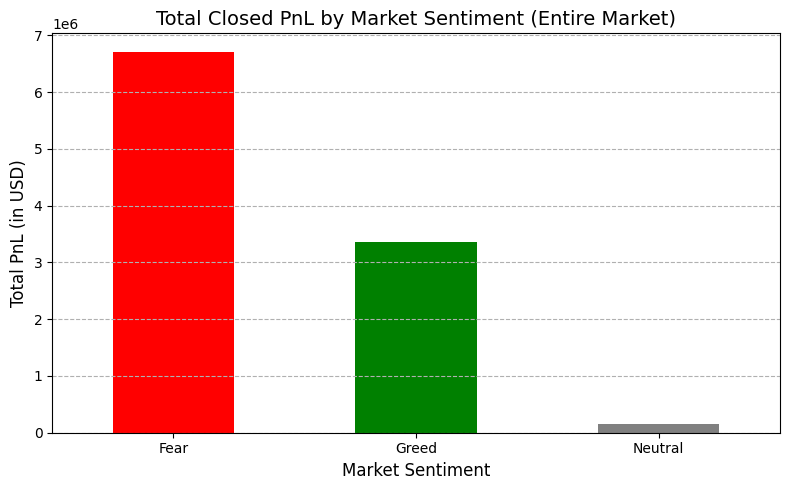

In [14]:
# --- 1. Aggregate Performance Analysis ---
sentiment_performance = final_df.groupby('Sentiment_Group').agg(
    Total_PnL=('Daily_Total_PnL', 'sum'),
    Avg_Daily_Total_PnL=('Daily_Total_PnL', 'mean'),
    Total_Volume_USD=('Daily_Volume_USD', 'sum')
).sort_values(by='Total_PnL', ascending=False)

print("\n--- AGGREGATE TRADER PERFORMANCE BY MARKET SENTIMENT ---")
print(sentiment_performance.map('{:,.2f}'.format))

# --- 2. Visualization: Total PnL by Sentiment (ds_/outputs/pnl_by_sentiment.png) ---
plt.figure(figsize=(8, 5))
sentiment_performance['Total_PnL'].plot(kind='bar', color=['red', 'green', 'grey'])
plt.title('Total Closed PnL by Market Sentiment (Entire Market)', fontsize=14)
plt.ylabel('Total PnL (in USD)', fontsize=12)
plt.xlabel('Market Sentiment', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()

# Save the plot
plt.savefig('pnl_by_sentiment.png')
print("\n✅ Chart 'pnl_by_sentiment.png' saved.")
plt.show() # Display the chart
plt.close()


--- SMART MONEY CONTRARIAN SIGNAL ---
Total Unique Accounts: 32, Smart Money Accounts (Top 10%): 4
                Smart_Money_PnL Net_Side_Bias
Sentiment_Group                              
Fear                  3,825,213            77
Greed                 1,097,012        -1,048
Neutral                  62,586           395

✅ Chart 'smart_money_bias.png' saved.


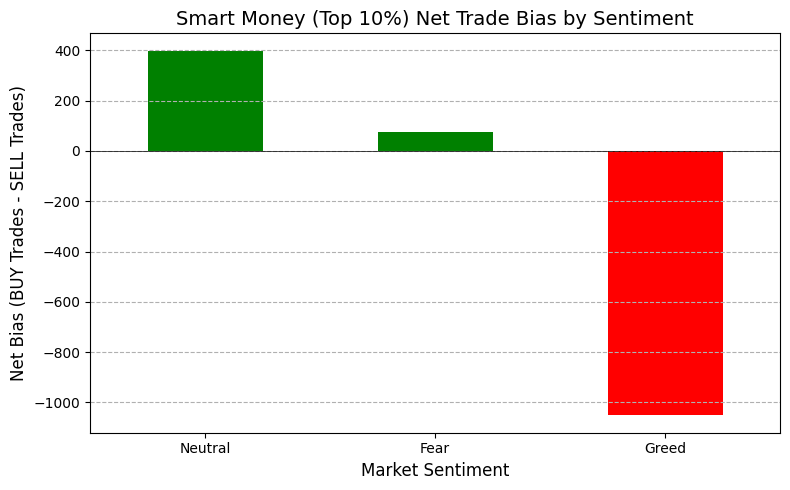

In [15]:
# --- 1. Identify "Smart Money" Accounts (Top 10% by PnL) ---
account_pnl = df_traders.groupby('Account')['Closed_PnL'].sum().reset_index()
account_pnl = account_pnl.sort_values(by='Closed_PnL', ascending=False)

num_accounts = len(account_pnl)
top_10_percent_count = int(np.ceil(0.10 * num_accounts))
smart_money_accounts = account_pnl.head(top_10_percent_count)['Account'].tolist()

df_smart_money = df_traders[df_traders['Account'].isin(smart_money_accounts)].copy()

# --- 2. Merge Smart Money Trades with Sentiment ---
df_smart_money_merged = pd.merge(
    df_smart_money,
    df_sentiment,
    left_on='Trading_Date',
    right_on='date',
    how='inner'
).drop(columns=['date'])

# --- 3. Analyze Smart Money Behavior by Sentiment (Net Side Bias) ---
smart_money_analysis = df_smart_money_merged.groupby('Sentiment_Group').agg(
    Smart_Money_PnL=('Closed_PnL', 'sum'),
    # Calculate Buy vs. Sell Bias (Count of 'BUY' - Count of 'SELL')
    Net_Side_Bias=('Side', lambda x: (x == 'BUY').sum() - (x == 'SELL').sum())
).sort_values(by='Smart_Money_PnL', ascending=False)

print("\n--- SMART MONEY CONTRARIAN SIGNAL ---")
print(f"Total Unique Accounts: {num_accounts}, Smart Money Accounts (Top 10%): {top_10_percent_count}")
print(smart_money_analysis.apply(lambda x: x.apply('{:,.0f}'.format)))

# --- 4. Visualization: Net Side Bias (ds_/outputs/smart_money_bias.png) ---
plt.figure(figsize=(8, 5))
bias_data = smart_money_analysis['Net_Side_Bias'].sort_values(ascending=False)
colors = ['green' if x > 0 else 'red' for x in bias_data]
bias_data.plot(kind='bar', color=colors)
plt.axhline(0, color='black', linewidth=0.5) # Zero line
plt.title('Smart Money (Top 10%) Net Trade Bias by Sentiment', fontsize=14)
plt.ylabel('Net Bias (BUY Trades - SELL Trades)', fontsize=12)
plt.xlabel('Market Sentiment', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()

# Save the plot
plt.savefig('smart_money_bias.png')
print("\n✅ Chart 'smart_money_bias.png' saved.")
plt.show() # Display the chart
plt.close()